In [11]:
#Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("CT2012.csv")

## Data exploration

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193274 entries, 0 to 193273
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_year              193274 non-null  int64  
 1   ori                    193274 non-null  object 
 2   pub_agency_name        193274 non-null  object 
 3   pub_agency_unit        2202 non-null    object 
 4   agency_type_name       193274 non-null  object 
 5   state_abbr             193274 non-null  object 
 6   state_name             193274 non-null  object 
 7   division_name          193274 non-null  object 
 8   county_name            193274 non-null  object 
 9   region_name            193274 non-null  object 
 10  population_group_code  193232 non-null  object 
 11  population_group_desc  193232 non-null  object 
 12  offense_code           193274 non-null  object 
 13  offense_name           193274 non-null  object 
 14  offender_race          108063 non-nu

In [13]:
df.head()

,data_year,ori,pub_agency_name,pub_agency_unit,agency_type_name,state_abbr,state_name,division_name,county_name,region_name,...,location_name,weapon_code,weapon_name,prop_desc_code,prop_desc_code.1,prop_desc_name,stolen_value,recovered_value,recovered_flag,date_recovered
0,2012,FL0160200,Jacksonville,NaN,City,FL,Florida,South Atlantic,DUVAL,South,...,Not Specified,12,Handgun,8.0,8.0,Consumable Goods,10000.0,10000,True,2012-07-25
1,2012,FL0160200,Jacksonville,NaN,City,FL,Florida,South Atlantic,DUVAL,South,...,Not Specified,12,Handgun,8.0,8.0,Consumable Goods,10000.0,10000,True,2012-07-25
2,2012,FL0160200,Jacksonville,NaN,City,FL,Florida,South Atlantic,DUVAL,South,...,Not Specified,12,Handgun,8.0,8.0,Consumable Goods,10000.0,10000,True,2012-07-25
3,2012,FL0160200,Jacksonville,NaN,City,FL,Florida,South Atlantic,DUVAL,South,...,Not Specified,12,Handgun,8.0,8.0,Consumable Goods,10000.0,10000,True,2012-07-25
4,2012,FL0160200,Jacksonville,NaN,City,FL,Florida,South Atlantic,DUVAL,South,...,Commercial/Office Building,12,Handgun,8.0,8.0,Consumable Goods,10000.0,10000,True,2012-07-25


## Data cleaning

We're going to drop pub_agency_unit, offender_race, and offender_ethnicity. They don't have enough rows (<50%) to make sense to include. We're also going to drop offense_code, prop_desc_code, prop_desc_code.1, weapon_code, population_group_code, location_code, victim_type_code, and state_abbr because they are repeats of data we have. 

In [14]:
#Dropping the useless columns
df = df.drop(["pub_agency_unit", "offender_race", "offender_ethnicity", "offense_code", "prop_desc_code", "prop_desc_code.1", "weapon_code", "population_group_code", "location_code", "victim_type_code", "state_abbr"], axis=1)


In [15]:
#Verify the changes we wanted took place
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193274 entries, 0 to 193273
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_year              193274 non-null  int64  
 1   ori                    193274 non-null  object 
 2   pub_agency_name        193274 non-null  object 
 3   agency_type_name       193274 non-null  object 
 4   state_name             193274 non-null  object 
 5   division_name          193274 non-null  object 
 6   county_name            193274 non-null  object 
 7   region_name            193274 non-null  object 
 8   population_group_desc  193232 non-null  object 
 9   offense_name           193274 non-null  object 
 10  offender_age           99481 non-null   float64
 11  offender_sex           108063 non-null  object 
 12  victim_type_name       193274 non-null  object 
 13  location_name          193274 non-null  object 
 14  weapon_name            15500 non-nul

## Exploring the data

<Axes: xlabel='stolen_value'>

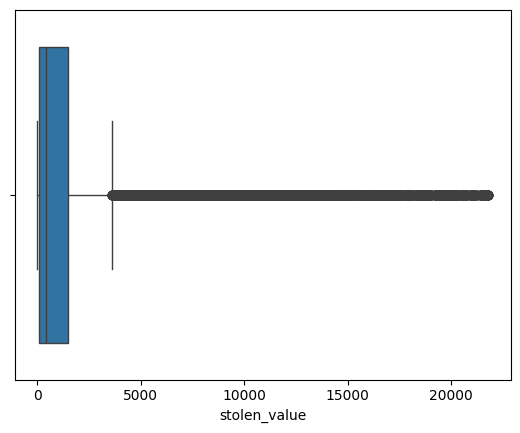

In [16]:

#From ChatGPT
#I drop the upper and lower 5% of data, as well as all values of $0 and $1 because they were both more than 10% of all values--I think this means they were catch-all values.
def drop_outliers(df, column_name, lower_percentile=5, upper_percentile=95, drop_values=[0, 1]):
    lower_bound = df[column_name].quantile(lower_percentile / 100)
    upper_bound = df[column_name].quantile(upper_percentile / 100)

    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound) & (~df[column_name].isin(drop_values))]

    return filtered_df
df = drop_outliers(df, column_name='stolen_value')


sns.boxplot(data = df, x = "stolen_value")

/var/folders/k1/b0_21mv5409283p9ml_l0yb40000gn/T/ipykernel_3171/1416166972.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='offender_sex', y='offender_age', data=df, palette='pastel')


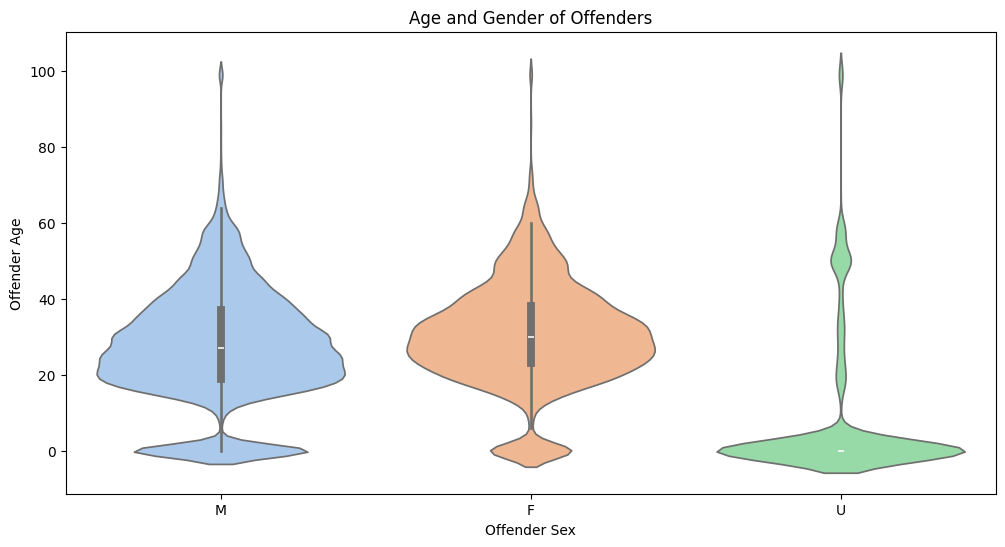

In [17]:
#Plotting offender age and sex
#23 offenders have sex "X" so we'll remove them
df = df[df['offender_sex'] != 'X']

plt.figure(figsize=(12, 6))
sns.violinplot(x='offender_sex', y='offender_age', data=df, palette='pastel')
plt.title('Age and Gender of Offenders')
plt.xlabel('Offender Sex')
plt.ylabel('Offender Age')
plt.show()

## Statistical analysis

What agency recovered the most cargo value?

In [18]:
#Use groupby to sort by pub_agency_name and then sum the recovered value. Find the max and the total.
#One issue with this is that many agencies did not report the value recovered (or recovered nothing of value, ever)
most_recovered_agency = df.groupby('pub_agency_name')['recovered_value'].sum().idxmax()
most_recovered_amount = df.groupby('pub_agency_name')['recovered_value'].sum().max()
madera_info = df.loc[df["pub_agency_name"] == most_recovered_agency].iloc[0]

print(most_recovered_agency, "with $" + str(most_recovered_amount), "recovered in the state of", madera_info["state_name"])

Las Vegas Metropolitan Police Department with $3781781 recovered in the state of Nevada


What was the most stolen from state, and how many thefts occured there?

In [19]:
#What is the most stolen from state?
mode_state = df['state_name'].mode().values[0]
print(mode_state)

#And how many times was a cargo theft committed there?
mode_count = (df['state_name'] == mode_state).sum()
print(str(mode_count) + " thefts, which is " + str(round(mode_count/df.shape[0] * 100, 2)) + "% of the country's total")


North Carolina
27345 thefts, which is 19.5% of the country's total


What state has the highest theft value per capita?

In [20]:
#Make dictionary with states and their sum stolen_values
state_stolen_value_dict = df.groupby('state_name')['stolen_value'].sum().to_dict()
#Remove Federal value. I assume it means govt theft caught by internal govt agencies.
state_stolen_value_dict.pop("Federal", None)
#Dictionary with state populations
state_pops = {"Alabama"	: 5024294, "Alaska" : 733374, 
"Arizona"	:7157902,
"Arkansas"	:3011490,
"California": 39538212,
"Colorado": 5773707,
"Connecticut": 3605912,
"Delaware": 989946,
"District of Columbia": 689548,
    "Florida": 21538216,
    "Georgia": 10713771,
    "Hawaii": 1455274,
    "Idaho": 1839117,
    "Illinois": 12813469,
    "Indiana": 6785442,
    "Iowa": 3190427,
    "Kansas": 2937835,
    "Kentucky": 4506297,
    "Louisiana": 4657785,
    "Maine": 1363177,
    "Maryland": 6177253,
    "Massachusetts": 7032933,
    "Michigan": 10077674,
    "Minnesota": 5706804,
    "Mississippi": 2961306,
    "Missouri": 6154889,
    "Montana": 1084244,
    "Nebraska": 1961965,
    "Nevada": 3104617,
    "New Hampshire": 1377524,
    "New Jersey": 9289039,
    "New Mexico": 2117525,
    "New York": 20202320,
    "North Carolina": 10439459,
    "North Dakota": 779079,
    "Ohio": 11799331,
    "Oklahoma": 3959411,
    "Oregon": 4237279,
    "Pennsylvania": 13002788,
    "Rhode Island": 1097371,
    "South Carolina": 5118422,
    "South Dakota": 886668,
    "Tennessee": 6910786,
    "Texas": 29145459,
    "Utah": 3271614,
    "Vermont": 643077,
    "Virginia": 8631373,
    "Washington": 7705267,
    "West Virginia": 1793713,
    "Wisconsin": 5893713,
    "Wyoming": 576850,
    "Guam": 168801}

#The below is from ChatGPT
# Merge state_stolen_value_dict and state_pops
merged_dict = {state: {'stolen_value': state_stolen_value_dict.get(state, 0),
                       'population': state_pops.get(state, 1)} for state in set(state_stolen_value_dict) | set(state_pops)}

# Create a DataFrame from the merged dictionary
merged_df = pd.DataFrame.from_dict(merged_dict, orient='index')

# Calculate per capita stolen value
merged_df['per_capita_stolen_value'] = merged_df['stolen_value'] / merged_df['population']

# Find the state with the highest per capita stolen value
state_highest_per_capita = merged_df['per_capita_stolen_value'].idxmax()

# Get the highest per capita stolen value
highest_per_capita_value = merged_df['per_capita_stolen_value'].max()

print(f"The state with the highest per capita stolen value is {state_highest_per_capita} with an average per capita stolen value of ${highest_per_capita_value:.2f}.")


The state with the highest per capita stolen value is North Carolina with an average per capita stolen value of $3.53.


![Screenshot 2024-02-06 at 9.31.25 AM.png](<attachment:Screenshot 2024-02-06 at 9.31.25 AM.png>)
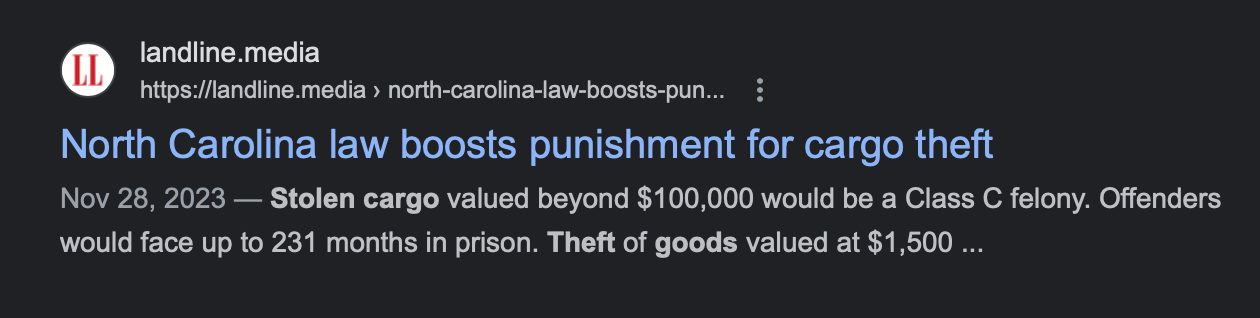

## Going forward

Because this data only is relevant to crimes after the fact, it could only help with officer/department resource distribution. At the same time, it's from 2012, so those conclusions probably wouldn't be that relevant. A more interesting analysis would be cargo theft trends over time. 